In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=90,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as sp
import pickle
import matplotlib.pyplot as plt
import scipy
import os
import time
from datetime import date
# import dask.dataframe as dd
# import dask.config
# dask.config.set({"distributed.scheduler.allowed-failures": 10})
today = date.today()
import os
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.read import read_single_cell_sql
from singlecell.preprocess import handle_nans, extract_cpfeature_names,find_highly_correlated_features
from singlecell.visualize import visualize_n_SingleCell, cluster
from singlecell.process import statistical_tests,precision_recall
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
from singlecell.save.save_pandas_dfs import saveDF_to_CSV_GZ_no_timestamp
from singlecell.preprocess.control_for_cellcount import control_feature_y_for_variable_x
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process import normalize_funcs
import scipy.stats as ss
import json

# %matplotlib inline  

DEBUG:jupyter_black:config: {'line_length': 90, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
# Function to calculate U statistics and p-values using Mann-Whitney U test for each feature
def calculate_stats(ds_params, feature_list, gene_list, df_genes, p_value):
    df_p_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)
    df_u_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)

    gene_counter = 0

    for feat in feature_list:
        list_p = []
        list_u = []
        for gene in gene_list:
            gene_counter += 1
            # Print status every 10 features
            if gene_counter / len(gene_list) % 10 == 0:
                print(f"now calculating feature number {gene_counter/len(gene_list)}")

            query_str = f'{ds_params["untreated_key_val"][0]} == "{ds_params["untreated_key_val"][1]}"'

            u, p = ss.mannwhitneyu(
                df_genes.query(query_str)[feat],
                df_genes.query("Metadata_Symbol == @gene")[feat],
                method="asymptotic",
            )

            list_p.append(p)
            list_u.append(u)

        df_p_values_feature[feat] = list_p
        df_u_values_feature[feat] = list_u

    df_u_values_feature = df_u_values_feature.apply(pd.to_numeric)
    df_p_values_feature = df_p_values_feature.apply(pd.to_numeric)

    df_p_values_feature.loc["sig_gene_count"] = 0

    for i in range(len(df_p_values_feature.columns)):
        count = 0
        for j in range(len(df_p_values_feature.index) - 1):
            if df_p_values_feature.iloc[j, i] <= p_value:
                count += 1
        df_p_values_feature.iloc[len(df_p_values_feature.index) - 1, i] = count

    return df_u_values_feature, df_p_values_feature


import numpy as np


def calculate_stats_2(ds_params, feature_list, gene_list, df_genes, p_value):
    df_p_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)
    df_u_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)

    # Query is done once
    untreated_df = df_genes.query(
        f'{ds_params["untreated_key_val"][0]} == "{ds_params["untreated_key_val"][1]}"'
    )

    for feat in feature_list:
        list_p = []
        list_u = []
        for i, gene in enumerate(gene_list):
            # Print status every 10 features
            #             if (i + 1) % 10 == 0:
            #                 print(
            #                     f"now calculating feature number {i+1}"
            #                 )

            gene_df = df_genes.query("Metadata_Symbol == @gene")[feat]

            u, p = ss.mannwhitneyu(untreated_df[feat], gene_df, method="asymptotic")

            list_p.append(p)
            list_u.append(u)

        df_p_values_feature[feat] = list_p
        df_u_values_feature[feat] = list_u

    df_u_values_feature = df_u_values_feature.apply(pd.to_numeric)
    df_p_values_feature = df_p_values_feature.apply(pd.to_numeric)

    # Vectorized comparison of p-values
    df_p_values_feature.loc["sig_gene_count"] = (df_p_values_feature <= p_value).sum(
        axis=0
    )

    return df_u_values_feature, df_p_values_feature

In [ ]:
calculate_stats

In [3]:
for profile_file, cell_line, condition in file_list:
    print (f"Now loading {profile_file}")
    df = pd.read_csv(os.path.join("../Profile_Aggregation/outputs",profile_file))
    df = df[df["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
    
    print ("Converting feature strings to ints")
    df_int_feats,features_dic_reverse = features_to_ints(df)
    
    describe_expression(df, cell_line)

    df_genes = df_int_feats.query("Metadata_Foci_Barcode_MatchedTo_GeneCode != 'nontargeting'")
    genes = list(df_genes.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    features_int = list(df_genes.columns)[2:]

    # Perform the statistics calculations for each feature
    print (f"Calculating statistics for {profile_file}")
    df_u_values , df_p_values = calculate_stats(features_int, genes, df_int_feats, p_value)

    # Return the ints to feature strings
    print (f'Converting ints to feature strings')
    df_p_values = df_p_values.rename(columns=features_dic_reverse)
    df_u_values = df_u_values.rename(columns=features_dic_reverse)
    df_p_values = df_p_values.reset_index(level=0).rename(columns={'index':'Gene'})
    df_u_values = df_u_values.reset_index(level=0).rename(columns={'index':'Gene'})
    if condition:
        df_p_values.to_csv(os.path.join(output_folder,f'{cell_line}_{condition}_significant_features_mann_whitney_p_values.csv.gz'),index=False)
        df_u_values.to_csv(os.path.join(output_folder,f'{cell_line}_{condition}_significant_features_mann_whitney_u_values.csv.gz'),index=False)
    else:
        df_p_values.to_csv(os.path.join(output_folder,f'{cell_line}_significant_features_mann_whitney_p_values.csv.gz'),index=False)
        df_u_values.to_csv(os.path.join(output_folder,f'{cell_line}_significant_features_mann_whitney_u_values.csv.gz'),index=False)


NameError: name 'file_list' is not defined

In [4]:
########################## Project root directory and path to results ########################
mito_project_root_dir = (
    "/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/"
)
save_results_dir = mito_project_root_dir + "/workspace/results/jump_fq/"


import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
import gc


def read_per_well_data(
    input_data_dir,
    annot,
    prof_workspace_folder_name="profiles",
    fformat=".parquet",
):
    batches = annot["Batch"].unique()

    df_agg_all_batches_ls = []
    for b in batches:
        print(b)
        #         if "Metadata_Source" in annot.columns:
        source_str = annot.loc[annot["Batch"] == b, "Metadata_Source"].unique()[0]
        #             print(source_str)
        profile_path = (
            input_data_dir + source_str + "/workspace/" + prof_workspace_folder_name + "/"
        )
        #         else:
        #             profile_path = input_data_dir + "/workspace/profiles/"

        df_sag_ls = []
        plates_exist = os.listdir(profile_path + b)
        plates_meta = annot.loc[annot["Batch"] == b, "Metadata_Plate"].unique()
        plates = set(plates_meta) & set(plates_exist)
        for p in plates:
            print(p)

            fileName = profile_path + b + "/" + p + "/" + p + fformat
            #             print(fileName)
            if os.path.exists(fileName):
                if fformat == ".parquet":
                    sc_df = pd.read_parquet(fileName)
                elif fformat in [".csv", ".csv.gz"]:
                    sc_df = pd.read_csv(fileName, dtype="float16")

                #         per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list+['Count_Cells']].reset_index()
                sc_df["Metadata_Batch"] = b
                sc_df["Metadata_Plate"] = p
                df_sag_ls.append(sc_df)
                del sc_df
                gc.collect()
            else:
                print(fileName, " not exists")

        if df_sag_ls:
            df_sag = pd.concat(df_sag_ls, axis=0)
            df_agg_all_batches_ls.append(df_sag)

    df_agg_all_batches = pd.concat(df_agg_all_batches_ls, axis=0)
    return df_agg_all_batches


lincs_meta_cols = [
    "Metadata_broad_sample",
    "Metadata_dose_recode",
    "Metadata_pert_id",
    "Metadata_pert_mfc_id",
    "Metadata_InChIKey14",
    "Metadata_pert_type",
    "Metadata_moa",
    "Metadata_target",
    "Metadata_pert_id_dose",
    "Metadata_pert_name",
]

# lincs_meta_cols=['Metadata_broad_sample','Metadata_dose_recode','Metadata_pert_id','Metadata_pert_mfc_id',\
# 'Metadata_InChIKey14','Metadata_pert_type','Metadata_pert_id_dose']

cdrp_meta_cols = [
    "Metadata_broad_sample",
    "Metadata_mmoles_per_liter2",
    "Metadata_pert_id",
    "Metadata_Sample_Dose",
    "Metadata_moa",
]
jumporf_meta_cols = ["Symbol", "broad_sample"]
jumpcrispr_meta_cols = ["Metadata_NCBI_Gene_ID", "Metadata_Symbol"]
jumpcompound_meta_cols = ["Metadata_InChIKey", "Metadata_InChI"]
taorf_meta_cols = [
    "Metadata_gene_name",
    "Metadata_pert_name",
    "Metadata_broad_sample",
    "Metadata_moa",
]


# jump_orf_params={'profiles_path':"/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/",\
#                  'meta_cols':jumporf_meta_cols,\
#                  'pert_col':'broad_sample',\
#                  'target_features_list':target_features_list_orf_cdrp
#                 }

jump_orf_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumporf_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_pert_type", "negcon"],
}

cdrp_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0012-wawer-bioactivecompoundprofiling/broad/workspace/backend/",
    "meta_cols": cdrp_meta_cols,
    "pert_col": "Metadata_Sample_Dose",
}
# /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/
# https://cellpainting-gallery.s3.amazonaws.com/cpg0004-lincs/broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00014812
lincs_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0004-lincs/",
    "prof_workspace_folder_name": "backend",
    "pformat": ".csv",
    "meta_cols": lincs_meta_cols,
    "pert_col": "Metadata_pert_id_dose",
    "untreated_key_val": ["Metadata_pert_type", "control"],
}

jump_crispr_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumpcrispr_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_Symbol", "non-targeting"],
}

jump_compound_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumpcompound_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_JCP2022", "JCP2022_999999"],
}

ta_orf_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0017-rohban-pathways/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".csv.gz",
    "meta_cols": taorf_meta_cols,
    "pert_col": "Metadata_broad_sample",
    "untreated_key_val": ["Metadata_pert_type", "Untreated"],
}

ds_info_dict = {
    "jump_orf": jump_orf_params,
    "CDRP": cdrp_params,
    "lincs": lincs_params,
    "lincs_g": lincs_params,
    "jump_crispr": jump_crispr_params,
    "jump_compound": jump_compound_params,
    "taorf": ta_orf_params,
}
# 'broad_sample', 'pert_type', 'control_type'

# results=annot[['Symbol','broad_sample', 'pert_type', 'control_type']].drop_duplicates().reset_index(drop=True)

# dataset='CDRP';dataset_meta_hue='Metadata_moa'
# dataset='lincs';dataset_meta_hue='Metadata_moa'
# dataset='jump_orf';dataset_meta_hue='Symbol'

In [15]:
df_rep_level_scaled[ds_info_dict[dataset]["untreated_key_val"][0]]

0           trt
1           trt
2           trt
3           trt
4           trt
          ...  
86690       trt
86691    poscon
86692    poscon
86693    poscon
86694    poscon
Name: Metadata_pert_type, Length: 86695, dtype: object

In [5]:
datasets = ["jump_orf", "jump_crispr"]

symbol_col = {
    "jump_crispr": "Metadata_Symbol",
    "jump_orf": "Metadata_Symbol",
    "taorf": "Metadata_gene_name",
}

# Define p-value to use for significance
p_value = 0.001

df_ls = []
# names=[]
ds_symbols = {}
ds_features = {}
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )
        if os.path.exists(file_path):
            df_rep_level_scaled = pd.read_csv(file_path)

            ds_symbols[dataset] = (
                df_rep_level_scaled[symbol_col[dataset]].unique().tolist()
            )

            (
                cp_features,
                cp_features_analysis_0,
            ) = extract_cpfeature_names.extract_cpfeature_names(df_rep_level_scaled)

            

            df_genes = df_rep_level_scaled[
                df_rep_level_scaled[ds_info_dict[dataset]["untreated_key_val"][0]]
                != ds_info_dict[dataset]["untreated_key_val"][1]
            ]

            genes = list(
                df_genes[~df_genes["Metadata_Symbol"].isnull()].Metadata_Symbol.unique()
            )
            
            sdfdsfds
            df_u_values, df_p_values = calculate_stats(
                ds_info_dict[dataset],
                cp_features_analysis_0,
                genes,
                df_rep_level_scaled,
                p_value,
            )
#             features_int = list(df_genes.columns)[2:]


#             ds_features[dataset] = cp_features_analysis_0

#             #             df_rep_level_scaled['']

#             #         batch_names_cols = DS_X_featureQ_rank_df.columns[
#             #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
#             #         ].tolist()
#             df_ls.append(df_rep_level_scaled)

NameError: name 'sdfdsfds' is not defined

In [61]:
df_rep_level_scaled.groupby('Metadata_Symbol').size().describe()

count    12602.000000
mean         6.815664
std         25.090888
min          4.000000
25%          5.000000
50%          5.000000
75%          5.000000
max       2026.000000
dtype: float64

In [93]:
# df_rep_level_scaled[df_rep_level_scaled['Metadata_Symbol'].isnull()]#['Metadata_Symbol']

In [64]:
# CCLE_expression_full
# OmicsExpressionProteinCodingGenesTPMLogp1
# CCLE_expression = pd.read_csv(
#     mito_project_root_dir + "workspace/metadata/JUMP/CCLE_expression_full.csv"
# )

CCLE_expression = pd.read_csv(
    mito_project_root_dir + "workspace/metadata/JUMP/CCLE_expression.csv"
)
CCLE_expression = CCLE_expression.loc[
    CCLE_expression[CCLE_expression.columns[0]].isin(["ACH-000364"])
]
CCLE_expression = (
    CCLE_expression.rename(columns={CCLE_expression.columns[0]: "Gene"})
    .transpose()
    .reset_index()
)
CCLE_expression.columns = CCLE_expression.iloc[0]
CCLE_expression = CCLE_expression[1:].rename(columns={"ACH-000364": "U2OS"})
# Simplify gene names
for i in range(len(CCLE_expression.index)):
    CCLE_expression.iloc[i, 0] = CCLE_expression.iloc[i, 0].split()[0]

(19221, 2)

In [90]:
CCLE_expression

,Gene,U2OS
1,TSPAN6,4.518535
2,TNMD,0.0
3,DPM1,6.673415
4,SCYL3,2.134221
5,C1orf112,4.106851
...,...,...
19217,ELOA3B,0.0
19218,NPBWR1,0.505891
19219,ELOA3D,0.0
19220,ELOA3,0.389567


In [68]:
# zero_express = CCLE_expression.query("U2OS == 0")

In [97]:
# zero_express_list
# zero_tpm_list
# zero_express_list
zero_express_list
zero_express
CCLE_expression.loc[CCLE_expression['U2OS']==0,"Gene"].unique().tolist()

['TNMD',
 'SLC22A16',
 'SLC4A1',
 'MPO',
 'PON1',
 'ASB4',
 'CACNG3',
 'TTC22',
 'UPP2',
 'SLC13A2',
 'CEACAM7',
 'SELE',
 'NOX1',
 'TFAP2B',
 'FMO1',
 'SLC6A7',
 'TYROBP',
 'SLC7A14',
 'NPC1L1',
 'CLCA4',
 'CYP3A43',
 'C8B',
 'SH2D2A',
 'IBSP',
 'MUSK',
 'MYOC',
 'STAP1',
 'OTC',
 'SLC18A1',
 'CASR',
 'C6',
 'SOX30',
 'C2orf83',
 'ZPBP',
 'LCP2',
 'GUCA2B',
 'UTS2',
 'ENTPD2',
 'SPO11',
 'ITIH1',
 'SERPINB3',
 'CREB3L3',
 'WNT8A',
 'ARSF',
 'POU1F1',
 'CD84',
 'ACSM2B',
 'ZFY',
 'STON1-GTF2A1L',
 'TRPC7',
 'GAL',
 'PRLH',
 'TRPC5',
 'CD5L',
 'NOX3',
 'SLC12A1',
 'RGS11',
 'NMRK2',
 'P2RY10',
 'BPIFB2',
 'LXN',
 'AFM',
 'RDH8',
 'DNAAF6',
 'CFHR2',
 'CACNA1S',
 'SLC13A1',
 'PGR',
 'COL19A1',
 'APOB',
 'FCN1',
 'TMPRSS11E',
 'DEFB127',
 'CPXM1',
 'F11',
 'SIRPG',
 'CFAP61',
 'SI',
 'CD209',
 'SLC26A3',
 'IL5RA',
 'APOH',
 'SLC17A6',
 'CMA1',
 'MYH7',
 'CEBPE',
 'DAZL',
 'TBL1Y',
 'VNN3',
 'OR1I1',
 'FMO2',
 'NXPE1',
 'KCNK16',
 'NCR2',
 'MLN',
 'PCDH11Y',
 'AMELY',
 'C22orf31',
 'UPK3A'

In [100]:
#     all_genes_list = list(df.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())

# zero_express = CCLE_expression.query("U2OS == 0")
# zero_express_list = list(zero_express.index)
zero_express_list=CCLE_expression.loc[CCLE_expression['U2OS']==0,"Gene"].unique().tolist()
zero_tpm_list=list(set(zero_express_list) & set(genes))

# zero_tpm_list = [value for value in zero_express_list if value in genes]
# zero_tpm_list = sorted(list(set(zero_tpm_list)))

expressed_gene_list0 = CCLE_expression.loc[CCLE_expression['U2OS']!=0,"Gene"].unique().tolist()
# expressed_gene_list0.remove("nontargeting")
expressed_gene_list=list(set(expressed_gene_list0) & set(genes))

print(f"There are {len(zero_express_list)} unexpressed genes in DepMap data")
print(f"There are {len(genes)} total genes in this dataset")
print(f"There are {len(zero_tpm_list)} unexpressed genes that are in this dataset")
print(f"There are {len(expressed_gene_list)} total expressed genes in this dataset")

CCLE_dict = {
    "zero_express": zero_express_list,
    "all_genes": genes,
    "zero_tpm": zero_tpm_list,
    "expressed_genes": expressed_gene_list,
}

There are 2151 unexpressed genes in DepMap data
There are 12598 total genes in this dataset
There are 1074 unexpressed genes that are in this dataset
There are 10948 total expressed genes in this dataset


In [94]:
# expressed_gene_list

In [10]:
%%time
genes = list(df_genes[~df_genes["Metadata_Symbol"].isnull()].Metadata_Symbol.unique())
df_u_values, df_p_values = calculate_stats_3(
    ds_info_dict[dataset], cp_features_analysis_0, genes, df_rep_level_scaled, p_value
)

# df_p_values.to_csv(os.path.join(save_results_dir+'hit_calling_periscope',f'{dataset}_significant_features_mann_whitney_p_values.csv.gz'),index=False)
# df_u_values.to_csv(os.path.join(save_results_dir+'hit_calling_periscope',f'{dataset}_significant_features_mann_whitney_u_values.csv.gz'),index=False)

CPU times: user 1d 15h 31min 49s, sys: 26.9 s, total: 1d 15h 32min 16s
Wall time: 1d 15h 32min 58s


In [11]:
df_p_values.to_csv(
    os.path.join(
        save_results_dir + "hit_calling_periscope",
        f"{dataset}_significant_features_mann_whitney_p_values.csv.gz",
    ),
    index=False,
)
df_u_values.to_csv(
    os.path.join(
        save_results_dir + "hit_calling_periscope",
        f"{dataset}_significant_features_mann_whitney_u_values.csv.gz",
    ),
    index=False,
)

In [12]:
df_u_values.shape, df_p_values.shape

((12598, 3439), (12599, 3439))

In [94]:
df_rep_level_scaled[cp_features_analysis_0].dtypes.unique()

,Cytoplasm_Correlation_Correlation_AGP_Mito,Nuclei_RadialDistribution_RadialCV_Mito_2of4,Cells_Correlation_RWC_Mito_RNA,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_mito_skel,Cells_Texture_DifferenceVariance_AGP_10_00_256,Cytoplasm_RadialDistribution_MeanFrac_ER_3of4,Cytoplasm_Texture_SumVariance_Mito_10_00_256,Cells_Texture_AngularSecondMoment_RNA_3_02_256,Cells_Texture_SumEntropy_AGP_3_01_256,Cytoplasm_Texture_Contrast_AGP_10_00_256,...,Cells_Texture_Variance_ER_10_01_256,Nuclei_Texture_DifferenceEntropy_Mito_5_00_256,Nuclei_Texture_DifferenceVariance_RNA_5_02_256,Cytoplasm_Granularity_7_AGP,Cytoplasm_Texture_DifferenceEntropy_Mito_5_02_256,Cytoplasm_Texture_SumVariance_ER_3_02_256,Nuclei_Texture_Contrast_ER_5_03_256,Cytoplasm_Texture_Correlation_RNA_5_00_256,Cytoplasm_Texture_AngularSecondMoment_RNA_3_03_256,Cytoplasm_Texture_Correlation_DNA_3_01_256
0,-4.078519,1.017456,0.931473,-0.185106,-0.678133,-3.289395,-0.217464,-0.845933,0.039717,-0.115612,...,-0.217967,-0.766831,-0.539388,-1.503087,1.082158,-0.310302,-0.181642,-4.290599,-0.658537,-0.455055
1,-1.418644,-1.090871,0.117515,-0.183150,-1.668838,-0.838895,-0.441549,-1.048859,0.949412,0.081594,...,-0.181482,-2.482151,-0.882217,-0.569334,-2.028242,-0.177361,-0.174464,-0.951070,-0.953078,-0.449130
2,-1.927235,-1.183465,0.030904,-0.183556,-1.210106,-0.822281,-0.440792,-1.128579,0.451688,-0.027988,...,-0.196538,-2.834825,-0.859025,-0.437363,-1.861065,-0.231886,-0.163938,-3.044415,-1.104118,-1.813724
3,-0.983126,-0.094787,0.073278,-0.182815,-0.367846,-1.013337,-0.449483,-0.723517,0.328804,-0.056842,...,-0.174392,-2.569599,-0.338696,-0.033172,-2.528636,-0.205628,-0.196874,-0.958245,-0.624729,-0.328254
4,-1.375635,0.015827,-0.005417,-0.183568,0.140368,-0.855508,-0.455787,-0.609281,-0.481877,-0.340929,...,-0.230084,-2.542692,-0.192425,-1.097991,-2.681028,-0.251919,-0.202507,-0.543219,-0.496794,0.777998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86690,0.405848,-0.593905,-0.418821,-0.240374,-0.349552,0.437161,-0.138298,-0.385294,0.033347,-0.440813,...,-0.242202,-0.584521,-0.380917,-0.594223,0.222374,-0.230513,-0.284064,-0.275724,-0.382601,-0.122592
86691,0.359407,-0.046262,-0.177550,-0.248134,-0.355998,0.361324,-0.138761,-0.393623,0.073462,-0.403920,...,-0.212300,-0.812724,-0.390151,-0.938273,-0.658300,-0.217109,-0.236567,-0.280696,-0.393000,-0.660125
86692,-0.112945,-0.212294,0.942664,-0.245432,-0.350957,0.249216,-0.137903,-0.391459,0.017777,-0.443520,...,-0.232612,-0.647614,-0.382071,-0.937725,0.844734,-0.220001,-0.277961,-0.359671,-0.390719,-0.760753
86693,0.273848,-0.259235,0.481351,-0.247292,-0.349389,-0.416834,-0.138796,-0.387036,0.047967,-0.439707,...,-0.157677,-0.714317,-0.383922,-0.939233,-0.235363,-0.180848,-0.192682,-0.316381,-0.385905,-0.703035


In [85]:
ls /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/jump_fq/hit_calling_periscope

jump_orf_significant_features_mann_whitney_p_values.csv.gz*
jump_orf_significant_features_mann_whitney_u_values.csv.gz*


In [ ]:
len(cp_features_analysis_0)

In [70]:
%%time
genes = list(df_genes[~df_genes['Metadata_Symbol'].isnull()].Metadata_Symbol.unique())
df_u_values , df_p_values = calculate_stats_2(ds_info_dict[dataset],cp_features_analysis_0[:3], genes, df_rep_level_scaled, p_value)


CPU times: user 48min 57s, sys: 1.64 s, total: 48min 59s
Wall time: 48min 46s


In [ ]:
# len(genes)

In [51]:
len(genes0)

12599

In [ ]:
# ds_params=ds_info_dict[dataset]
# feature_list=cp_features_analysis_0
# gene_list=genes
# df_p_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)
# df_u_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)

# gene_counter = 0

# for feat in feature_list:
#     list_p = []
#     list_u = []
#     for gene in gene_list:
#         gene_counter += 1
#         # Print status every 10 features
#         if gene_counter / len(gene_list) % 10 == 0:
#             print(
#                 f"now calculating feature number {gene_counter/len(gene_list)}"
#             )

#         query_str = f'{ds_params["untreated_key_val"][0]} == "{ds_params["untreated_key_val"][1]}"'

#         u, p = ss.mannwhitneyu(
#             df_rep_level_scaled.query(
#                 query_str
#             )[feat],
#             df_rep_level_scaled.query(
#                 "Metadata_Symbol == @gene"
#             )[feat],
#         )

#         list_p.append(p)
#         list_u.append(u)

#     df_p_values_feature[feat] = list_p
#     df_u_values_feature[feat] = list_u

# df_u_values_feature = df_u_values_feature.apply(pd.to_numeric)
# df_p_values_feature = df_p_values_feature.apply(pd.to_numeric)

# df_p_values_feature.loc["sig_gene_count"] = 0

# for i in range(len(df_p_values_feature.columns)):
#     count = 0
#     for j in range(len(df_p_values_feature.index) - 1):
#         if df_p_values_feature.iloc[j, i] <= p_value:
#             count += 1
#     df_p_values_feature.iloc[len(df_p_values_feature.index) - 1, i] = count


In [46]:
gene_list.index(gene)

170

In [ ]:
# df_rep_level_scaled.query(
#     "Metadata_Symbol == @gene"
# )[feat],

In [ ]:
# gene_list

In [6]:
def calculate_stats_for_gene(gene, untreated_df, feat, gene_to_indices):
    try:
        gene_indices = gene_to_indices[gene]
        gene_df = df_genes.loc[gene_indices, feat]
        u, p = ss.mannwhitneyu(untreated_df[feat], gene_df, method="asymptotic")
    except Exception as e:
        print(f"Exception occurred for gene {gene} and feature {feat}: {str(e)}")
        u, p = np.nan, np.nan

    return p, u


def calculate_stats_3(ds_params, feature_list, gene_list, df_genes, p_value):
    df_p_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)
    df_u_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)

    untreated_df = df_genes.query(
        f'{ds_params["untreated_key_val"][0]} == "{ds_params["untreated_key_val"][1]}"'
    )

    # Create a dictionary mapping each gene to the indices of the rows that correspond to it
    gene_to_indices = (
        df_genes.reset_index().groupby("Metadata_Symbol")["index"].apply(list).to_dict()
    )

    for feat in feature_list:
        for gene in gene_list:
            p, u = calculate_stats_for_gene(gene, untreated_df, feat, gene_to_indices)
            df_p_values_feature.loc[gene, feat] = p
            df_u_values_feature.loc[gene, feat] = u

    df_u_values_feature = df_u_values_feature.astype("float64")
    df_p_values_feature = df_p_values_feature.astype("float64")

    df_p_values_feature.loc["sig_gene_count"] = (df_p_values_feature <= p_value).sum(
        axis=0
    )

    return df_u_values_feature, df_p_values_feature

In [ ]:

# df_u_values , df_p_values = calculate_stats(ds_info_dict[dataset],cp_features_analysis_0, genes, df_rep_level_scaled, p_value)

In [ ]:
#             df_u_values , df_p_values = calculate_stats(ds_info_dict[dataset],cp_features_analysis_0, genes, df_rep_level_scaled, p_value)


In [ ]:
# df_genes["Metadata_Symbol"]

In [23]:
ds_info_dict[dataset][pert_col]

{'profiles_path': '/home/ubuntu/gallery/cpg0016-jump/',
 'prof_workspace_folder_name': 'profiles',
 'pformat': '.parquet',
 'meta_cols': ['Symbol', 'broad_sample'],
 'pert_col': 'Metadata_JCP2022',
 'untreated_key_val': ['Metadata_pert_type', 'negcon']}

In [74]:
# import numpy as np
# import pandas as pd
# from multiprocessing import Pool


# def calculate_stats_for_gene(params):
#     gene, untreated_df, feat, df_genes = params
#     try:
#         gene_df = df_genes.query("Metadata_Symbol == @gene")[feat]
#         u, p = ss.mannwhitneyu(
#             untreated_df[feat],
#             gene_df,
#             method="asymptotic"
#         )
#     except Exception as e:
#         print(f"Exception occurred for gene {gene} and feature {feat}: {str(e)}")
#         u, p = np.nan, np.nan

#     return p, u

# def calculate_stats_3(ds_params, feature_list, gene_list, df_genes, p_value):
#     df_p_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)
#     df_u_values_feature = pd.DataFrame(index=gene_list, columns=feature_list)

#     # Query is done once
#     untreated_df = df_genes.query(f'{ds_params["untreated_key_val"][0]} == "{ds_params["untreated_key_val"][1]}"')

#     for feat in feature_list:
#         with Pool() as p:
#             results = p.map(calculate_stats_for_gene, [(gene, untreated_df, feat, df_genes) for gene in gene_list])
        
#         p_values, u_values = zip(*results)
#         df_p_values_feature[feat] = p_values
#         df_u_values_feature[feat] = u_values

#     df_u_values_feature = df_u_values_feature.apply(pd.to_numeric)
#     df_p_values_feature = df_p_values_feature.apply(pd.to_numeric)

#     # Vectorized comparison of p-values
#     df_p_values_feature.loc["sig_gene_count"] = (df_p_values_feature <= p_value).sum(axis=0)

#     return df_u_values_feature, df_p_values_feature

## Plots

In [ ]:
os.mkdir("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/jump_fq/hit_calling_periscope")

In [21]:
ls /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/jump_fq/hit_calling_periscope

jump_orf_significant_features_mann_whitney_p_values.csv.gz*
jump_orf_significant_features_mann_whitney_u_values.csv.gz*


In [23]:
peris_repo = "/home/ubuntu/workspace_periscope/2022_PERISCOPE/"
# Import annotated gene sets
with open(peris_repo + "/common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

# Load CORUM data
CORUM_data = pd.read_csv(peris_repo + "/common_files/CORUM_humanComplexes.txt", sep="\t")
# Load STRING data
STRING_data = pd.read_csv(peris_repo + "/common_files/STRING_data.csv.gz")

In [59]:
CCLE_expression_per = pd.read_csv(
    peris_repo + "/Hit_Calling/inputs/CCLE_expression_HeLa_A549.csv"
)



In [60]:
CCLE_expression_per

,Gene,A549,HeLa
0,TSPAN6,5.176323,4.541019
1,TNMD,0.000000,0.000000
2,DPM1,6.310522,6.581803
3,SCYL3,2.017922,1.650765
4,C1orf112,4.058316,3.904002
...,...,...,...
19172,POLR2J3,3.372952,5.452530
19173,H2BE1,0.000000,0.000000
19174,AL445238.1,0.000000,0.000000
19175,GET1-SH3BGR,0.214125,0.238787


In [ ]:
# Load p_values from the hit calling process
root_pval_dir="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/jump_fq/hit_calling_periscope/"
df_p_values = pd.read_csv(root_pval_dir+'/jump_orf_significant_features_mann_whitney_p_values.csv.gz')
df_p_values = df_p_values.set_index('Gene')

In [19]:
df_p_values.columns[
    df_p_values.columns.str.contains("Nuclei_Texture_InfoMeas2_.*3_01_256")
]

Index(['Nuclei_Texture_InfoMeas2_RNA_3_01_256',
       'Nuclei_Texture_InfoMeas2_AGP_3_01_256',
       'Nuclei_Texture_InfoMeas2_DNA_3_01_256',
       'Nuclei_Texture_InfoMeas2_ER_3_01_256',
       'Nuclei_Texture_InfoMeas2_Mito_3_01_256'],
      dtype='object')

In [ ]:
phalloidin (actin) and WGA (Golgi and plasma membrane)

F-actin cytoskeleton, Golgi,
plasma membrane
AGP

In [104]:
# def FDR_5_2(control_sig_feature, channel_list):
#     total = len(control_sig_feature)
#     FDR_5 = int(total / 20)
#     channel_values = {channel: 0 for channel in channel_list}
#     c = 200

#     for channel in channel_list:
#         feat_5 = 0
#         while feat_5 <= FDR_5:
#             feat_5 = len(control_sig_feature.query(f"{channel} > @c"))
#             channel_values[channel] = c + 1
#             c -= 1

#     return tuple(channel_values[channel] for channel in channel_list)


# def FDR_5_2(control_sig_feature, channel_list):
#     total = len(control_sig_feature)
#     FDR_5 = int(total / 20)
#     channel_values = {channel: 0 for channel in channel_list}
#     c = 200

#     for channel in channel_list:
#         mask = control_sig_feature[channel] > c
#         feat_5 = mask.sum()
#         while feat_5 <= FDR_5:
#             c -= 1
#             mask = control_sig_feature[channel] > c
#             feat_5 = mask.sum()
#         channel_values[channel] = c + 1

#     return tuple(channel_values[channel] for channel in channel_list)


def FDR_5_3(control_sig_feature, channel_list):
    total = len(control_sig_feature)
    FDR_5 = int(total / 20)
    channel_values = {channel: 0 for channel in channel_list}
    c = 200

    for channel in channel_list:
        mask = control_sig_feature[channel] > c
        feat_5 = mask.sum()
        while feat_5 <= FDR_5 and c > 0: # add condition to exit if c <= 0
            c -= 1
            mask = control_sig_feature[channel] > c
            feat_5 = mask.sum()
        channel_values[channel] = c + 1

    return tuple(channel_values[channel] for channel in channel_list)

In [114]:
df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]

channel_list = ["Mito", "ER", "AGP", "DNA", "RNA","Sum"]
thresholds = FDR_5_3(df_sig_feature_zero_tpm, channel_list)

# Generate dictionary mapping channel names to their thresholds
threshold_dict = dict(zip(channel_list, thresholds))

# Generate query strings
whole_cell_query = f'Sum > {threshold_dict["Sum"]}'
comp_spec_query = ' | '.join([f'{channel} > {threshold_dict[channel]}' for channel in channel_list if channel != 'Sum'])

# Query the dataframe
A549_whole_cell_hits = df_sig_feature_expressed.query(whole_cell_query)
A549_comp_spec_hits = df_sig_feature_expressed.query("Sum <= @sum_5").query(comp_spec_query)


In [116]:
# A549_whole_cell_hits

In [112]:
# expressed_gene_list
# zero_tpm_list
# df_sig_feature
# df_sig_feature.loc[zero_tpm_list]

In [117]:
# mito_5, er_5, agp_5, dapi_5, rna_5, sum_5 = FDR_5_3(
#     df_sig_feature_zero_tpm, ["Mito", "ER", "AGP", "DNA", "RNA","Sum"]

# A549_whole_cell_hits = df_sig_feature_expressed.query("Sum > @sum_5")
# A549_comp_spec_hits = df_sig_feature_expressed.query("Sum <= @sum_5").query(
#     "Mito > @mito_5 | ER > @er_5 | AGP > @agp_5 | DNA > @dapi_5 | RNA > @rna_5"
# )

hit_list = list(A549_comp_spec_hits.index) + list(A549_whole_cell_hits.index)
# df_hits = df_gene.loc[df_gene.index.isin(hit_list)]
# df_hits.head()

NameError: name 'df_gene' is not defined

In [20]:
# Extract the features
features = df_p_values.columns.to_list()
mito_list = [feature for feature in features if "_mito" in feature.lower()]
cona_list = [feature for feature in features if "_er" in feature.lower()]
dapi_list = [feature for feature in features if "_dna" in feature.lower()]
wga_list = [feature for feature in features if "_agp" in feature.lower()]
phalloidin_list = [feature for feature in features if "_rna" in feature.lower()]
print(
    "Number of features per compartment: ",
    "\n",
    "Mito features: ",
    len(mito_list),
    "\n",
    "ER features: ",
    len(cona_list),
    "\n",
    "DNA features: ",
    len(dapi_list),
    "\n",
    "AGP features: ",
    len(wga_list),
    "\n",
    "RNA features: ",
    len(phalloidin_list),
)

Number of features per compartment:  
 Mito features:  835 
 ConA features:  673 
 DNA features:  664 
 WGA features:  673 
 RNA features:  674


In [43]:
# hit_list


In [29]:
p_value = 0.001
gene_list = list(df_p_values.index)
compartment_lists = {
    "Mito": mito_list,
    "ER": cona_list,
    "AGP": wga_list,
    "DNA": dapi_list,
    "RNA": phalloidin_list,
    "Sum": features,
}

df_sig_feature = pd.DataFrame(index=gene_list)

for compartment, feat_list in compartment_lists.items():
    mask = df_p_values[feat_list] < p_value
    df_sig_feature[compartment] = mask.sum(axis=1)

df_sig_feature.head()

,Mito,ER,AGP,DNA,RNA,Sum
PCDHA8,506,422,404,441,399,2163
DNM2,496,489,416,438,514,2345
RHBDF1,572,399,386,453,436,2245
EPB41L1,419,437,468,419,428,2151
FSTL5,543,407,366,381,409,2111


In [ ]:
df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]
A549_whole_cell_hits = df_sig_feature_expressed.query('Sum > @sum_5')

In [121]:
# Function to calculate percentage of significant number of features from each channel
def df_maker(gene_group, df_genes, column_list):
    means = df_genes[column_list].mean()
    sum_all = df_genes["Sum"].mean()

    for column in column_list:
        data.loc[gene_group, column] = means[column] / sum_all * 100

    return data


# Organize the data into a dataframe
gene_groups = [
    "Vacuolar-type ATPase",
    "Protein O-mannosylation",
    "Outer Mitochondrial Membrane Protein Complex",
    "Cortical Cytoskeleton",
    "DNA Polymerase Complex",
]
data = pd.DataFrame(index=gene_groups)

for gene_group in gene_groups:
    gene_group_list = gene_set_dict[gene_group]
    df_genes = df_sig_feature.loc[set(gene_group_list) & set(gene_list)]
    df_genes = (
        df_genes.reset_index()
        .query("index in @expressed_gene_list")
        .query("index in @hit_list")
    )
    data = df_maker(gene_group, df_genes, ["Mito", "ER", "AGP", "DNA", "RNA"])

data

/tmp/ipykernel_129208/3392350151.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_genes = df_sig_feature.loc[set(gene_group_list) & set(gene_list)]
/tmp/ipykernel_129208/3392350151.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_genes = df_sig_feature.loc[set(gene_group_list) & set(gene_list)]
/tmp/ipykernel_129208/3392350151.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_genes = df_sig_feature.loc[set(gene_group_list) & set(gene_list)]
/tmp/ipykernel_129208/3392350151.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_genes = df_sig_feature.loc[set(gene_group_list) & set(gene_list)]
/tmp/ipykernel_129208/3392350151.py:24: FutureWarning: Passing a set as an indexer is deprecated and wil

,Mito,ER,AGP,DNA,RNA
Vacuolar-type ATPase,20.381630,21.012770,19.594808,18.822713,21.641807
Protein O-mannosylation,20.362509,20.793063,19.486346,19.775389,21.058019
Outer Mitochondrial Membrane Protein Complex,20.637012,20.879831,19.890473,18.588551,21.419715
Cortical Cytoskeleton,20.946539,20.762952,19.766130,18.615213,21.150769
DNA Polymerase Complex,19.323195,21.393096,20.230126,18.052257,22.309282


<IPython.core.display.Javascript object>


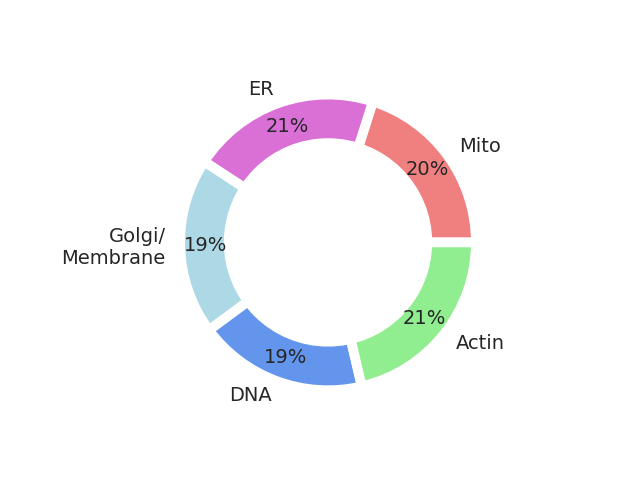

Vacuolar-type ATPase


<IPython.core.display.Javascript object>


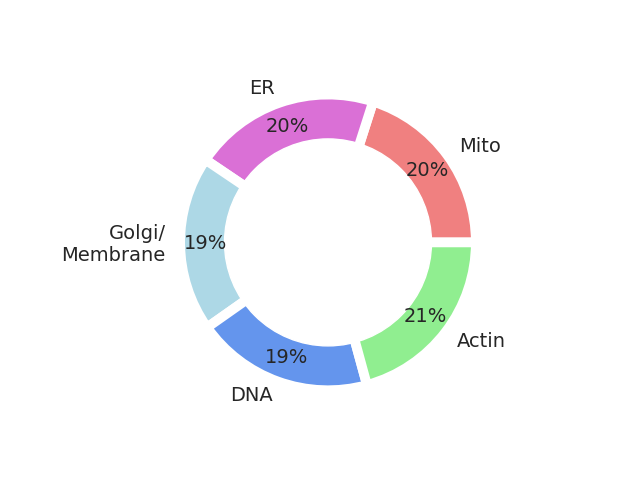

Protein O-mannosylation


<IPython.core.display.Javascript object>


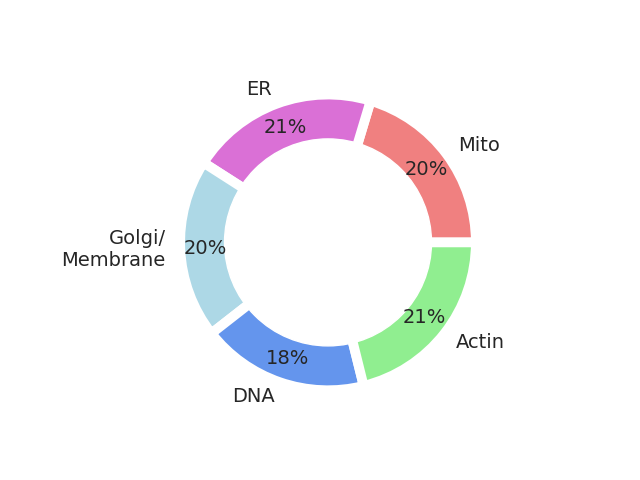

Outer Mitochondrial Membrane Protein Complex


<IPython.core.display.Javascript object>


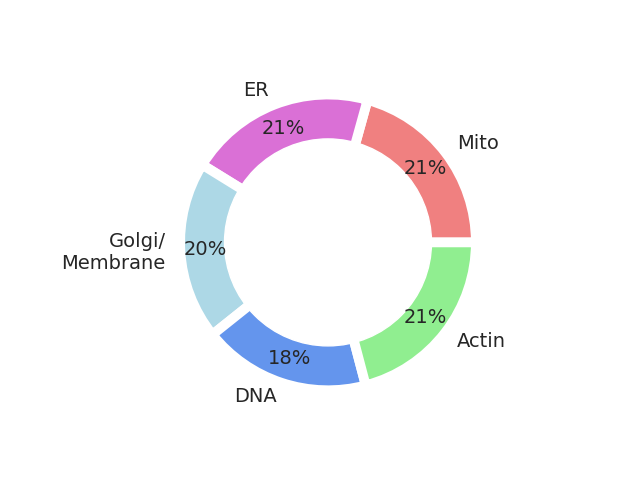

Cortical Cytoskeleton


<IPython.core.display.Javascript object>


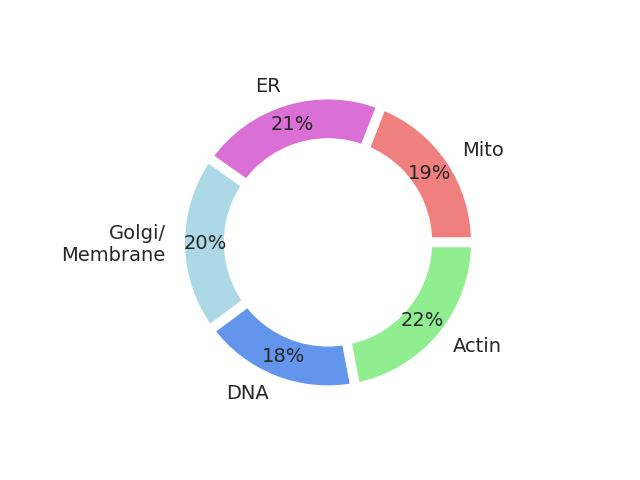

DNA Polymerase Complex


In [122]:
# Plot fraction of features per compartments for Fig 2E
for group in list(data.index):
    plt.figure()
    print(group)
    group_name = group.replace(" ", "_")
    names = ["Mito", "ER", "Golgi/\nMembrane", "DNA", "Actin"]
    size = data.loc[group].values

    # Create a circle at the center of the plot
    my_circle = plt.Circle((0, 0), 0.7, color="white")

    # Custom wedges
    plt.pie(
        size,
        labels=names,
        wedgeprops={"linewidth": 7, "edgecolor": "white"},
        colors=["lightcoral", "orchid", "lightblue", "cornflowerblue", "lightgreen"],
        autopct="%1.0f%%",
        pctdistance=0.83,
        textprops={"fontsize": 14},
    )
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    #     plt.savefig(
    #         os.path.join(
    #             output_folder,
    #             "figure_panels",
    #             f"Fig2E_A549_fraction_features_per_compartments_{group_name}.png",
    #         ),
    #         dpi=300,
    #         facecolor="w",
    #         edgecolor="w",
    #         bbox_inches="tight",
    #     )
    plt.show()

In [37]:
# df_genes

In [38]:
# df_genes

In [ ]:
data = pd.DataFrame(index=gene_groups)

for gene_group in gene_groups:
    gene_list = gene_set_dict[gene_group]
    df_genes = df_sig_feature.loc[gene_list]
    df_genes = (
        df_genes.reset_index()
        .query("index in @expressed_gene_list")
        .query("index in @hit_list")
    )
    data = df_maker(gene_group, df_genes)

data